<a href="https://colab.research.google.com/github/adarsh-saji/Deep_learning_projects/blob/main/Neural_style_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Dense, AveragePooling2D, MaxPooling2D, Input, Conv2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

In [2]:
import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [3]:
def VGG16_AvgPool(shape):

  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)


  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:

      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

In [4]:
def vgg_cutoff(shape, num_convs):

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)


In [5]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [6]:
def scale(x):
  x = x = x - x.min()
  x = x / x.max()
  return x

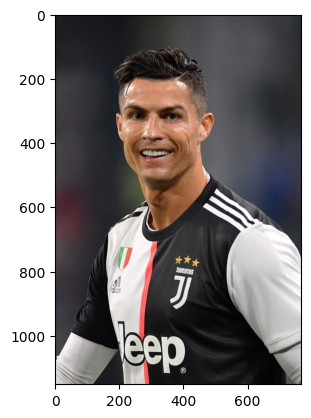

58889256/58889256 [==============================] - 1s 0us/step


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 1152, 768, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 1152, 768, 3), dtype=float32)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [7]:
if __name__ == '__main__':

  path = '/content/drive/MyDrive/Ronaldo.jpg'
  img = image.load_img(path)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)

  batch_shape = x.shape
  shape = x.shape[1:]

  plt.imshow(img)
  plt.show()

  content_model = vgg_cutoff(shape, 12)

  target = K.variable(content_model.predict(x))
  loss = K.mean(K.square(target - content_model.output))

  grad = K.gradients(loss, content_model.input)

  get_grad_and_loss = K.function(inputs = [content_model.input],
                                 outputs = [loss] + grad)

  def wrapper(x_vec):
     l, g = get_grad_and_loss([x_vec.reshape(*batch_shape)])
     return l.astype(np.float64), g.flatten().astype(np.float64)


iter=0, loss=117.592041015625
iter=1, loss=62.3394775390625
iter=2, loss=42.969268798828125
iter=3, loss=33.37895584106445
iter=4, loss=27.498611450195312
iter=5, loss=23.82384490966797
iter=6, loss=21.258447647094727
iter=7, loss=19.23710823059082
iter=8, loss=17.755083084106445
iter=9, loss=16.48433494567871
duration: 0:03:03.307054


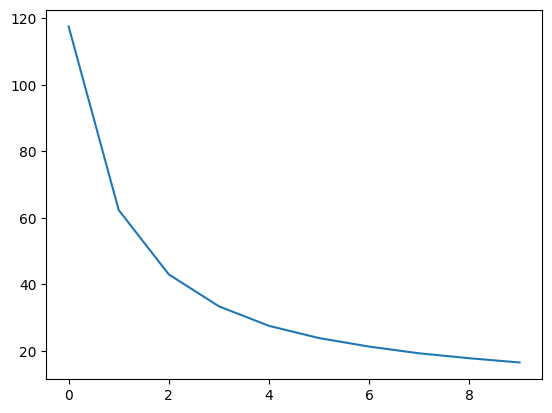

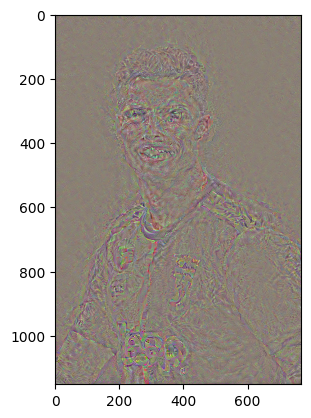

In [8]:
from datetime import datetime
t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=wrapper,
      x0=x,

      maxfun=20
    )
    x = np.clip(x, -127, 127)

    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)


plt.imshow(scale(final_img[0]))
plt.show()

### **Style Model**

In [9]:
def gram_matrix(img):
    X = tf.transpose(img, perm=[2, 0, 1])
    X = tf.reshape(X, (tf.shape(X)[0], -1))  # Flatten the spatial dimensions
    G = tf.linalg.matmul(X, tf.transpose(X)) / tf.cast(tf.reduce_prod(tf.shape(img)), tf.float32)
    return G


In [10]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [11]:
def min(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
        func = fn,
        x0 = x,
        maxfun = 20
    )
  x = np.clip(x, -127, 127)
  print("iter=%s, loss=%s" % (i, l))

  losses.append(l)
  print('Duration: ', datetime.now() - t0)
  plt.plot(losses)

  new_image = x.reshape(*batch_shape)
  final_img = unpreprocess(new_image)
  return final_img[0]

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, None, None, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, None, None, 3), dtype=float32)


iter=9, loss=20.299314498901367
Duration:  0:03:45.528350


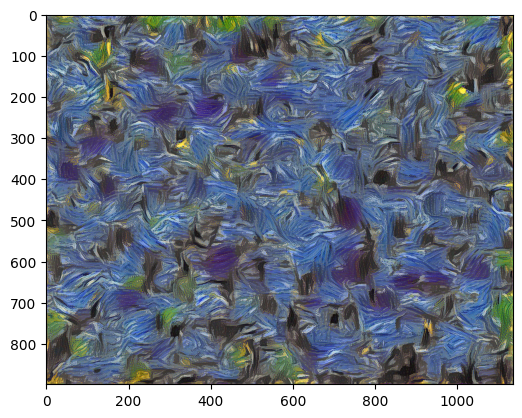

In [12]:
if __name__ == '__main__':

  path = '/content/drive/MyDrive/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

  img = image.load_img(path)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)

  batch_shape = x.shape
  shape = x[1:]

  vgg = VGG16_AvgPool(shape)

  symbolic_conv_output = [
      layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
  ]

  multi_output_model = Model(vgg.input, symbolic_conv_output)

  style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]


  loss = 0
  for symbolic, actual in zip(symbolic_conv_output, style_layers_outputs):

    loss += style_loss(symbolic[0], actual[0])

  grads = K.gradients(loss, multi_output_model.input)


  get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
  )

  def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


  final_img = min(get_loss_and_grads_wrapper, 10, batch_shape)
  plt.imshow(scale(final_img))
  plt.show()

##**Style Transfer**

In [14]:
def load_img_and_preprocess(path, shape = None):
  img = image.load_img(path, target_size = shape)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  return x

In [15]:
content_image = load_img_and_preprocess('/content/drive/MyDrive/Ronaldo.jpg')

In [29]:
h,w = content_image.shape[1:3]
style_image = load_img_and_preprocess('/content/drive/MyDrive/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', shape = (h,w))

In [30]:
batch_shape = content_image.shape
shape = content_image.shape[1:]

In [18]:
vgg = VGG16_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_3:0", shape=(None, 1152, 768, 3), dtype=float32)


In [31]:
content_model = Model(vgg.input,vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_image))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_3:0", shape=(None, 1152, 768, 3), dtype=float32)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [32]:
symbolic_conv_output = [
    layers.get_output_at(1) for layers in vgg.layers if layers.name.endswith('conv1')
]

style_model = Model(vgg.input, symbolic_conv_output)
style_target = [K.variable(y) for y in style_model.predict(style_image)]

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_3:0", shape=(None, 1152, 768, 3), dtype=float32)


In [34]:
style_weights = [0.2,0.4,0.3,0.5,0.2]

loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_output, style_layers_outputs):

  loss += w * style_loss(symbolic[0], actual[0])
grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


In [ ]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = min(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale(final_img))
plt.show()

In [1]:
# i was not able to complete the final plotting the style transfered image since my system kept on crashing